In [1]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import itertools

# Exercise 1 - REINFORCE

The goal of this exercise is to implement the simplest policy gradient algorith, REINFORCE, and then augment it with a baseline coming from an approximation of the value function. We will use this algorithm on the inverted pendulum model. The class below defines the pendulum model and some helper function to simulate it.

In [2]:
class Pendulum:
    """
    This class describes an inverted pendulum and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class
        """
        #gravity constant
        self.g=9.81
        
        # number of dimensions (angle and angular velocity)
        self.num_states = 2
        
        # the available control inputs
        self.controls = np.array([-5., 0., 5.])
        self.nb_controls = len(self.controls)

        # the maximum velocity
        self.vmax = 6.
        # the range of allowable states
        self.state_range = np.array([[0, 2*np.pi],[-self.vmax, self.vmax]])

        #simulation step
        self.delta_t = 0.1
        # internal integration step
        self._internaldt = 0.01
        self._integration_ratio = int(round(self.delta_t / self._internaldt))
        
            
    def step(self,x,u):
        """
        This function integrates the pendulum for one step of self.delta_t seconds
        
        Inputs:
        x: state of the pendulum (x,v) as a 2D numpy array
        u: control as a scalar
        
        Output:
        the state of the pendulum as a 2D numpy array at the end of the integration
        """
        x_next = x[0]
        v_next = x[1]
        for i in range(self._integration_ratio):
            x_next = (x_next + self._internaldt * v_next)%(2*np.pi)
            v_next = np.clip(v_next + self._internaldt * (u-self.g*np.sin(x_next)), -self.vmax, self.vmax)
        return np.array([x_next,v_next])
    
    def simulate(self, x0, policy, T):
        """
        This function simulates the pendulum for T seconds from initial state x0 using a policy
        (policy is called as policy(x) and returns one control)
        
        Inputs:
        x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
        T: the time to integrate for
        
        Output:
        x (2D array) and u (1D array) containing the time evolution of states and control
        """
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = policy(x[:,i])
            x[:,i+1] = self.step(x[:,i], u[i])
        return x, u

In [3]:
def animate_pendulum(x, dt):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """
    
    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    plotx = x[:,::steps]
    
    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)
    
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])
        
        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

This function can be used to plot the results of a simulation of the pendulum

In [4]:
def plot_results(pend, val, pol, policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = pend.simulate(x0, policy, 10)

    plt.figure(figsize=[6,6])
    plt.imshow(val, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    plt.figure(figsize=[6,6])
    plt.imshow(pol, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')
    if animate:
        animate_pendulum(x, pend.delta_t)

## Reinforcement learning problem

We would like to get the pendulum upright starting from the down rest position. It has two states, its angle $\theta$ (where $\theta=0$ means that the pendulum is down) and its angular velocity $\omega$. The state of the system is $x = [\theta^T \omega^T]^T$. We also assume that we have only 3 possible control inputs $[-5, 0, 5]$.

We formulate this problem as a finite horizon problem where we want to minimize the cost
$$\min \sum_{i=0}^{N} \alpha^i g(\theta_i, \omega_i, u_i)$$
where the instantaneous cost is $$g(x,v,u) = (x-\pi)^2 + 0.01 v^2 + 0.00001 u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls

## Stochastic policies

We will use stochastic policies $\pi(u | x,\theta_\pi)$ that are parametrized by $\theta_\pi$ (i.e. the parameters to learn). We will use exponential softmax distributions $$\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$$ where in the denominator we sum over the 3 possible controls.
The function $h(x,u,\theta_\pi)$ is a function which reflects the preference of a control for a given state. We will use a linear combination of nonlinear basis functions to define it as
$$h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$$
where $$\Psi(x,u) = [\psi_0(x,u), \cdots, \psi_m(x,u)]^T$$ is a vector of $m$ nonlinear basis functions.
In our exercise, we use periodic basis functions. For a given order $p$, we define $m = 6 (p+1)^2$ basis functions as
$$\psi_{k,l,c,0}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
and
$$\psi_{k,l,c,1}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
where $0\leq k \leq p$ and $0 \leq l \leq p$ are integers, $u_c$ is the control indexes by $c$ (i.e. it is either -5, 0 or 5) and $\omega_{max}$ is the maximum velocity of the pendulum (in order to get one period over the full range of $\omega$). Note that $\theta$ already ranges from $0$ to $2\pi$.

The class below defines these stochastic policies as well as helper functions to sample from the policy, get the vector of basis functions and get the probability distribution $\pi(.|x,\theta_\pi)$

In [5]:
class StochasticPolicyPeriodicFeatures:
    """
    This class implements a stochastic policy with linear sum of nonlinear features
    the features are periodic functions multiplied by a radial basis function of u
    """
    def __init__(self, controls, order = 2):
        """
        class constructor - controls is the array of control inputs, order is the order of the periodic basis
        """
        self.controls =  controls.copy()
        self.num_controls = len(self.controls)
        self.exp_basis = np.zeros([self.num_controls])
        self.order = order
        
        # the vector of basis functions
        self.basis_vector = np.zeros([2*self.num_controls*(self.order+1)**2])
        
        # the linear parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x, u):
        """
        Returns the vector of basis functions evaluated at x,u
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for c in self.controls:
            du = 1/(np.sqrt(2*np.pi*0.001)) * np.exp(-(u-c)**2/0.002)
            for j,k in itertools.product(range(self.order+1), range(self.order+1)):
                self.basis_vector[count] = du * np.cos(j*dx + k*dy)
                self.basis_vector[count+1] = du * np.sin(j*dx + k*dy)
                count += 2
        return self.basis_vector

    def get_distribution(self, x):
        """ 
        Computes pi(u|x) for all u 
        returns an array of pi and an array of basis functions (row is the control index and column is the )
        """
        dist = np.zeros_like(self.controls)
        basis_fun = np.zeros([len(self.theta), len(self.controls)])
        for i,u in enumerate(self.controls):
            # this gives the basis function evaluated as (x,u)
            basis_fun[:,i] = self.basis(x,u)
            # dist gives exp(theta * basis_function)
            dist[i] = np.exp(self.theta.dot(basis_fun[:,i]))

        # we sum the exponentials
        sm = np.sum(dist)
        # dist is rescaled by the sum of exponentials (we now have a probability distribution)
        dist = dist/sm
        return dist, basis_fun
    
    def sample(self, x):
        """
        sample from the stochastic policy given x
        it returns the index of the control and its value
        """
        probs, basis = self.get_distribution(x)
        index = np.random.choice(len(self.controls), p=probs)
        return index, self.controls[index]

## Value function approximation

We also use a function approximator for the value function (used for the REINFORCE algorithm with baseline). We will write our approximation of the value function as
$$V(x,\theta_V) = \theta_V^T B(x)$$
where the vector of basis functions $B$ is also constituted of periodic functions of the form
$$b_{k,l,0}(\theta,\omega) = \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$ and
$$b_{k,l,1}(\theta,\omega) = \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$

The class below implements such a value function approximation

In [6]:
class ValueFunctionPeriodicFeatures:
    """
    This class implements a function approximator with linear sum of nonlinear features
    the features are periodic functions
    We use this to approximate the value function
    """
    
    def __init__(self, order = 2):
        """
        the class constructor - order is the order of the periodic basis
        """
        
        self.order = order
        self.basis_vector = np.zeros([2*(self.order+1)**2])

        # the parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x):
        """
        Returns the vector of basis functions evaluated at x
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for j,k in itertools.product(range(self.order+1), range(self.order+1)):
            self.basis_vector[count] = np.cos(j*dx + k*dy)
            self.basis_vector[count+1] = np.sin(j*dx + k*dy)
            count += 2
        return self.basis_vector
    
    def getValue(self, x):
        """
        returns the value at x and the basis functions evaluated at x
        """
        bs = self.basis(x)
        return bs.dot(self.theta), bs

## REINFORCE

We want to implement the REINFORCE algorithm (where an iteration is shown below):
1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
2. For each step $t$ of the episode
 * compute the return $G_t = \sum{k=t}^T \alpha^{k-t}g(x_k, u_k)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t G_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ is a learning rate
 
 ## REINFORCE with baseline
 
 The REINFORCE with baseline algorithm, in addition, maintains an estimate of the value function. One iteration is
 1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
 2. For each step $t$ of the episode
 * compute the return $G_t = \sum{k=t}^T \alpha^{k-t}g(x_k, u_k)$
 * $\delta_t = G_t - V(x_t, \theta_V)$
 * do gradient ascent on the value parameters $\theta_V \leftarrow \theta_V + \gamma_V \alpha^t \delta_t \nabla V(x_t, \theta_V)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t \delta_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ and $\gamma_V$ are learning rates

## Questions

a) Compute $\nabla V(x, \theta_V)$ with respect to $\theta_V$ for a generic function $ V(x, \theta_V) = \theta_V^T B(x)$

b) Compute $\nabla \ln \pi(u_t | x_t, \theta_\pi)$ with respect to $\theta_\pi$ for a stochastic policy parametrized as $\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$, with $h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$

c) using the previous computations, the classes above (optional) and code skeleton below (also optional), implement the REINFORCE algorithm for the inverted pendulum. Use $\alpha = 0.99$, an episode length of 100 (i.e. 10 seconds) and order p=2 for the policy approximation. Hint: you may want to choose a learning rate between $10^{-8}$ and $10^{-11}$. How many episodes does it take to converge? Can the resulting policy (which is stochastic) balance the pendulum appropriately? (note you may want to test several times due to the stochasticity). Plot the learning progress (costs versus episodes), you may also want to use a moving average over the costs to remove noise.

d) implement the REINFORCE algorithm with baseline and answer the same questions as in c) (also use an order p=2 for the value function approximation). Additionally, plot the value function. Hint: you may want to choose a learning rate between $10^{-6}$ and $10^{-9}$ for updating the policy and a learning rate between $10^{-1}$ and $10^{-3}$ to update the value function.

e) Compare the convergence rate of both algorithms. Which one seem to be easier to use?

You can use the code skeleton below to answer the questions

### Solution a 

$ V(x, \theta_V) = \theta_V^T B(x)$

$\rightarrow \nabla_\theta V(x, \theta_V) = B(x)$

In [ ]:
def compute_nabla_V(B):
        return B

### Solution b
$\nabla_\theta\log(\pi_\theta(u,x)) = \nabla_\theta\log(e^{\psi(u,x)^\intercal\theta}) - \nabla_\theta\log(\sum_{k=1}^Ne^{\psi(x,u)^\intercal\theta})$

Now as, $\nabla_\theta\log(e^{\psi(x,u)^\intercal\theta}) = \nabla_\theta\psi(x,u)^\intercal\theta = \psi(x,u)    $&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;. . .(1)

And, $\nabla_\theta\log(\sum_{k=1}^Ne^{\psi(x,u)^\intercal\theta}) = \frac{\nabla_\theta\sum_{k=1}^Ne^{\psi(x,u)^\intercal\theta}}{\sum_{k=1}^Ne^{\psi(x,u)^\intercal\theta}}$

Taking the gradient of the numerator we get:

$\nabla_\theta\log(\sum_{k=1}^Ne^{\psi(x,u)^\intercal\theta}) = \frac{\sum_{k=1}^N{\psi(x,u)}e^{\psi(x,u)^\intercal\theta}}{\sum_{k=1}^Ne^{\psi(x,u)^\intercal\theta}}$

$\Rightarrow \sum_{k=1}^N{\psi(x,u)}\pi_\theta(x,u) \Rightarrow \mathrm{E}_{\pi_\theta}[\psi(s,\cdot)]      $&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;. . .(2)

Since, $\pi$ represents probabilities.

Now, combining (1) and (2):

$\nabla_\theta\log(\pi_\theta(u,x)) =  \psi(x,u) - \mathrm{E}_{\pi_\theta}[\psi(x,\cdot)]$


In [17]:
def compute_nabla_lnpi(theta,psi,probs_dist,index):
    expectation_psi = psi[:,0]*(probs_dist[0])+ psi[:,1]*(probs_dist[1])+psi[:,2]*(probs_dist[2])
    nabla_lnpi = psi[:,index] - expectation_psi
    return nabla_lnpi

### Solution c

In [30]:
class Reinforce:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy, discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 0.000001):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
            
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  
            # generate an episode - start from 0
            
            x_traj[0,:] = np.zeros([2]) 
            for j in range(self.episode_length):
                u_index[j],u_traj[j] = self.policy.sample(x_traj[j,:])
                x_traj[j+1,:] = self.model.step(x_traj[j,:],u_traj[j]).transpose()
                cost_traj[j] = cost(x_traj[j,:],u_traj[j])
            for j in range(self.episode_length):
                Gt = 0
                for k in range(j,self.episode_length):
                    Gt = Gt + (self.discount_factor**(k-j))*cost_traj[k]
                dist,psi = self.policy.get_distribution(x_traj[j,:])
                self.policy.theta =  self.policy.theta - self.policy_learning_rate*(self.discount_factor**j)*Gt*compute_nabla_lnpi(self.policy.theta, psi,dist,u_index[j])
            learning_progress.append(Gt)                
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                # val[i,j] = self.value.getValue(np.array([x,v]))[0]
                
        return pol, val

def cost(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.00001*u
    #return 10000*(x[0] - np.pi)**2 + 10*x[1]**2 + 1*u

In [31]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
# to be used for the baseline
# value = ValueFunctionPeriodicFeatures(order = 2)
reinforce = Reinforce(pendulum, cost, policy, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate = 1e-7)

<IPython.core.display.Javascript object>


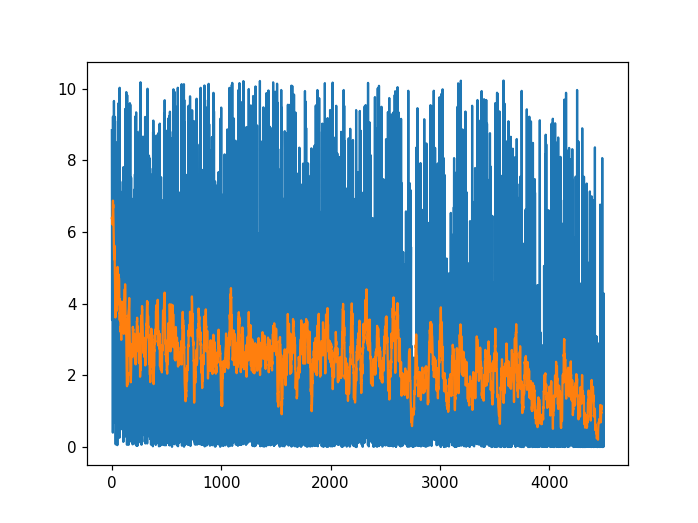

<IPython.core.display.Javascript object>


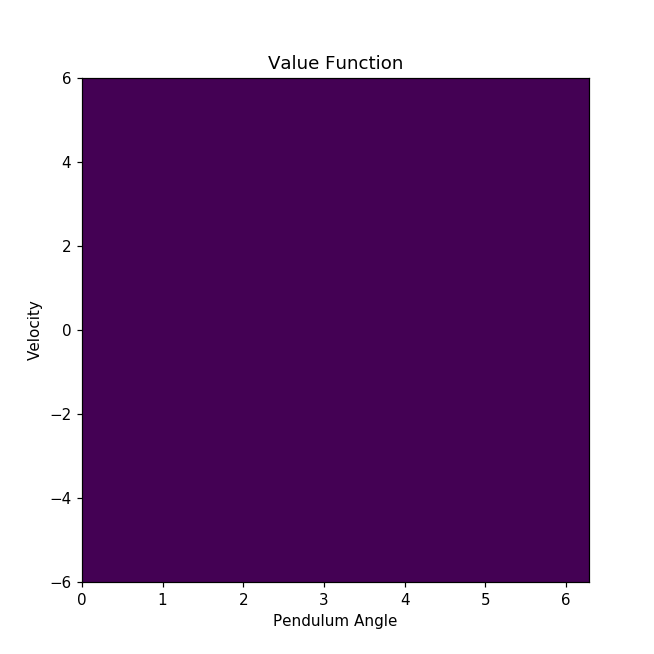

<IPython.core.display.Javascript object>


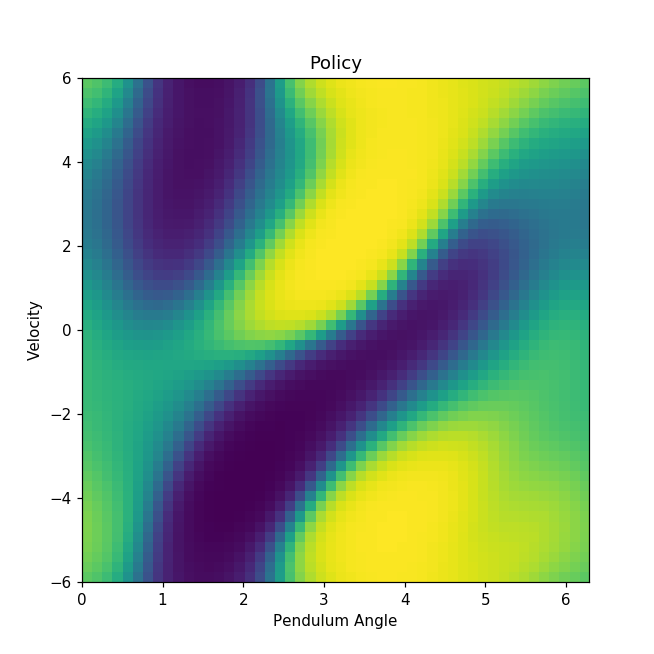

<IPython.core.display.Javascript object>


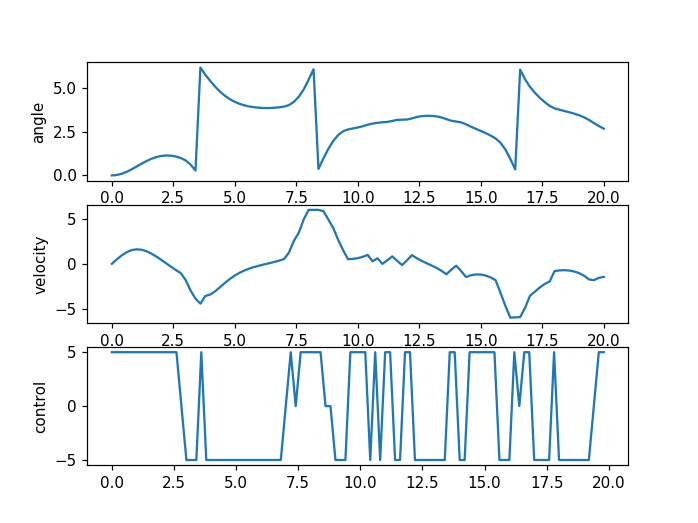

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAADI4m1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0ZZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAUeHteuN3YNbSdAAABrAA6Qix/9v
pDjcAE/ZYPzWIy/xaAfWoiuIxPmK2D7zN1SWOL4zZ8ixj9mJWyafzaQPJPgumMKQ5V59n8tUzfUD
S0tnaGINepwNygSCAo62Nj0Ixhv5SVoJFUYpmvY7OlceVopm0K7e9iLYzS+7C8RJRANe5oQnlmwO
88l0TgfHNasAcBupheGfaeEXLZmHWO+X2fTyHC+vtQ7TaNefQ7CHnR1luQXnqFHjCK+JT2UKks+S
SQu/lDZN9tIlTOxSY5hxurCa6TP3YdJ0Pua9/TkOkZla1StT2B/gDsnAFBf2/aRZPeVxVbYpe4QY
vnQkmk29MQ1rmTd5xqtt8rxwNyDuYzoDXLAPOxYEsVRbvzcXRjk6RTGwtB793KDTq6XQij4Oj1LG
DzySMsX8uhgbYXdN7nIelHVZmr+bBLug14JvybnvwTIRdvyeogAubMfy1/YSd/mjDkL+VFIk3uor
BCtV2FftGmbYiX0kSoMMBhwrwGr/Ap+Q0l5Q+EF9XjzawE1OQzWCRkf+/hqGJ1Zqv4o8ppo1i9gT
HfIIcv6mtXXQrHNZ5SW1+X8sDaru82cU/6mDvAAWWuUTbBQfyx5GxcLnqexfshUiZjj45768ehLA
s2eJLYzPFtXV2hBtoLo8p8iHsN2cGqodACK9lqyUHPtRjqISqhcrtfR/MNY8F59nygAudtZ5wAAA
SwwUcqaY5AkvpzvgAbgXMusVE5UI3xjdJZ59YGeFULlnFgp1TO5i2Liv14oliSHmEgBfyvgJUGY+
viPF+3slMUUNvjN5qDbvlyPftQmotWoNmZ6iC0u8C3rP+VolIc5XUS8OjIuf8+99oyVmDgnwL+uW
yGUSnfzpEjITPMoHipGodbevjJX1X0F6rCm8V5jAZJkfrIUfs1o8wenrTyZwr+tv43dX5mNUeujW
bg8q4UUJhfhLpQymn0daDLmbMkn8dEOLXf/aKMKniiwZJE/FD699QeRHlreyr5t1bLv8RKIorWt8
wd/EvYIhRl07SktlA0WxBvm2f8//vw0abkWifMiZ4DhWbEhdcKi2KUZu5aQ+IjQtDHS5eMhW1GWg
s3/Y7KXjPFqmmETJm1mhjCwDh3Sxn5kIlF5X7yxFjqgOQ/RTVbKyvoEqh/m5JfyhZTyy2FktQvYZ
Jr163JZE8G1xuVHr6PP2PPpwoidw/2auyKpLkDaA9SmwwhtaYdhKOJknWTWXdYOwrYbM1SHkWE13
luBzCHdd0TlmtGTJBsVRJbjFi0boEx3sIWQRYNgucjM4gWsQMZziS2F6D537qZh0uwQ2jS+GwZhR
isjatGJb/Nm1c7U9fbyfqiaKN/F+BDZCUSkAc3xGzEfpMwP7Y7M9A6jQ2q0p1vcbToIcIP4GD5Pf
yPN/DOBZojpiqYajrW6zaoEzKCsEYf+F47A6BvxvzTcS/Cy521lE7M9hp7rI7QlMs9fQkA/PZMI7
tUCWBDtUNGFJ0gjqAc0IQQz1xVGQUfKoWQJTif2Z5IChQb+8TuzQAAN+OJNLgBxHftLNtoE36r49
81/UIESb8FFcuh8MECVlrV1ofiIWLI5/5FQcf0LG2fuQjrKCGbF0ZvV+1wQdhDqm5jovCbCb1vUQ
em7F3pn/LyD9c4pZAl/ei4IAFtG63TOD1SU2SKjpQZbDXX8ahCrx+a9sPh1FL9VuX/CBEpR9jo5+
DOE7astiJ9DbSrz3CbwAyPMiofogYPkHuyW6tztStTQ/ht59dkVvg10Z0u4nLNK+jEixjgGe+Ywj
xCswyEeDovWNJmhauiE9+/hPV0J6Z1hwG3mDvIKlUFr6H4DM/4p7rbN54sCEt6Sv1+IMwBEsCfLZ
9VIp6xzCSYltkQC8iKIbNvxhCKZiv5+fP1b9iOG0y48IC9G1M3qWa273MK9Ek45lqlmDvIYdKI7F
A8e/rnTdytLSC6aejc8ji5/qU9cI4/Ssi1tQWaEgvNyIust4iLONJ5wjbaLZ5iLU8EtfZY9eCYtP
/swxpAg4KoHDhg7/SzRvpbMicXacJa9dWKPpuga6NNvNVd+1fcuQ1EZae04P5H+goctTwvLdzpYK
IminPSzq9ITCAXNZ0OlweA+dJw5w3ZrfSzP9ugA2AS8x2AgddrUr3HLrWaakxL3SQMptDdUgojLs
lETmkEerFRN6ki3MN5koU+g0yA+v+kI15bKbVgdzF/iq2sI24bBLXupxz8Oto5E8SPFumtC45EnE
WM15GOOo/hp+wfL8mNB1gBg7HH9JPm8hla+vpcMTbIt5LtZThTTwl/+ZzSJzTTt/G71Qf3BxnYQr
ijbdLemmHWifeFX/9zrR9fiipzckUejrT6Yk66Zc6AAAez2/2DoykrYaHF7uyMwh8yOuu+U0ibQH
W4sEMvtJgFWsqTDZB2gbJZPH/WRexL8o4xtFt5ULaFPx6jgxmNpYWSimPU8aLGd1d7ZAzJgHLEeM
GayCe4PqhCn8YDqLwVReiJUtaVv5ksXPPT0fnTPmytQ3aZ54zaNpnouLFgGhPB5jaP4nAMMSP/Og
k1qozztygXS72mxbRUsY0Q1M1lgjrnId6XKq6MbZ63VAW2KVILty9EUc/NzgbGbNT1wwPPbW2Sm9
lykVqIHUs7gSK2fv6PDoDB5c0z0S7+LOZ9lelvH/ZtgXHnuSECCVZFkxFcL7B1WiOdhrs2YdqvIp
WOzuHjDRuJdJabQIr5QjoqwjWPQy//wQ/i4d0fesjrrdNxW04xty9X+XdUrTEH4gUWBL8tZ8z9Aj
MFxl68NSaO/+Ya0F6TI6xaywfAxK9I05QHoZZliCak+PIz4zojo7Sm/i/Xjqsbl6iadI1vknITst
oFfLgO3IIjcFoeXghYrhb

In [32]:
# here we learn doing 300 episodes
lear = reinforce.iterate(4500) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear)
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
#print(pol)
#print(val)
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)

### Answers:
The convergence is variable but it gives good enough results for anything greater than 4000.
The resulting policy is nearly able to keep the pendulum position upright, Though the pendulum slightly wavers from the target position.

### Solution d

In [26]:
class Reinforce_with_baseline:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy,value, discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 0.000001, value_learning_rate = 0.01):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        self.value = value
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
        self.value_learning_rate = value_learning_rate    
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        Gt = 0
        for i in range(num_iter):  
            # generate an episode - start from 0
            
            x_traj[0,:] = np.zeros([2]) 
            for j in range(self.episode_length):
                u_index[j],u_traj[j] = self.policy.sample(x_traj[j,:])
                x_traj[j+1,:] = self.model.step(x_traj[j,:],u_traj[j]).transpose()
                cost_traj[j]=cost_baseline(x_traj[j,:],u_traj[j])
            for j in range(self.episode_length):
                Gt = 0
                for k in range(j,self.episode_length,1):
                    Gt = Gt + (self.discount_factor**(k-j))*cost_traj[k]
                delta = Gt - self.value.getValue(x_traj[j,:])[0]
                self.value.theta = self.value.theta + self.value_learning_rate*(self.discount_factor**j)*delta*compute_nabla_V(self.value.getValue(x_traj[j,:])[1])
                dist,psi = self.policy.get_distribution(x_traj[j,:])
                self.policy.theta =  self.policy.theta - self.policy_learning_rate*(self.discount_factor**j)*delta*compute_nabla_lnpi(self.policy.theta, psi,dist,u_index[j])
            learning_progress.append(Gt)
                
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                val[i,j] = self.value.getValue(np.array([x,v]))[0] 
        return pol, val

def cost_baseline(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.00001*u
    #return 10000*(x[0] - np.pi)**2 + 10*x[1]**2 + 1*u

In [14]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
# to be used for the baseline
value = ValueFunctionPeriodicFeatures(order = 2)
reinforce = Reinforce_with_baseline(pendulum, cost, policy,value, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate = 1e-6, value_learning_rate = 1e-2)

<IPython.core.display.Javascript object>


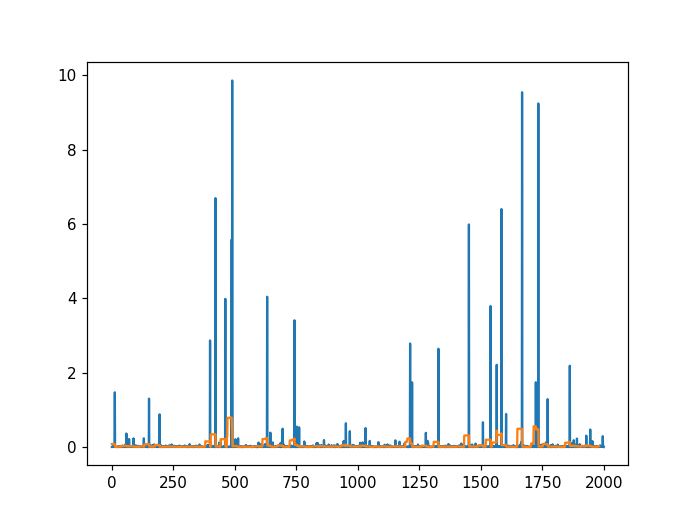

<IPython.core.display.Javascript object>


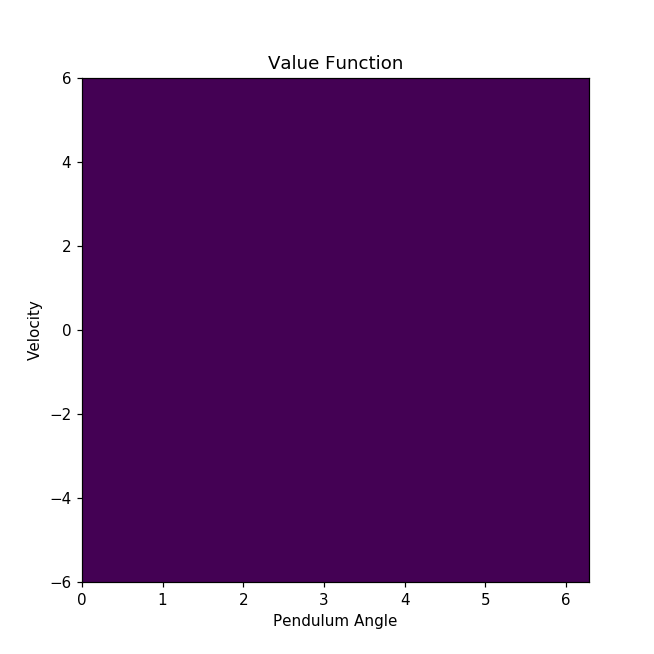

<IPython.core.display.Javascript object>


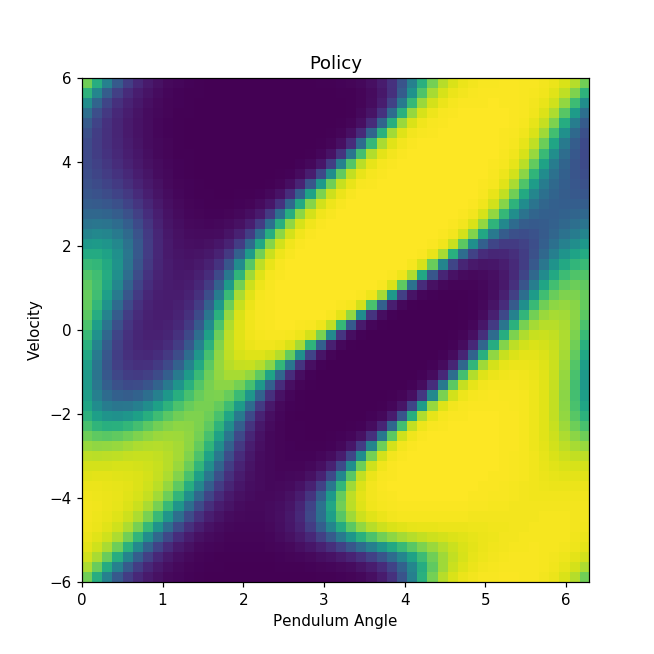

<IPython.core.display.Javascript object>


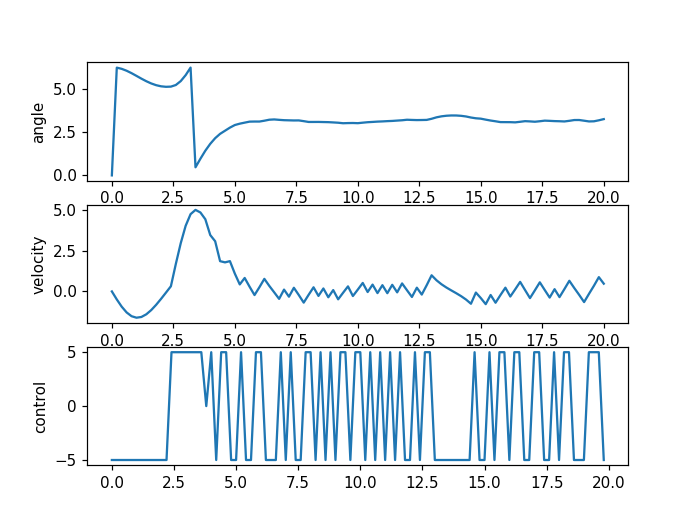

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACFNW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA0jZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAFbekZYZCdC/yYgAABXwAsgZkmelx
SROADzDHsnTdNPwqh0IYXPcgsx/VdOgPtpJk3xmz25oQD2NxIJATjjPFHtCPYSSyrz7P5apm+qGo
CaO0hQa9TgblAkEBRtsbJoJjDfyhjQSKoxTNex2bKxAqRTNoM297EWxml92F4SgqAa9lbwbZ8+3M
8l0TfdHNaygcBuoe/stRvUXLZinWJDX2fTyHC+vsg7SSDh9VCALo/f8LntmbRMOk0qgXCi/HjrLA
aDHF+z18yVLK2z74iGw43VhNdJn7sOk6H3E21bAuxha9GcFT2B/gDsnAFBY5gBiZPeVxVbYpe4QY
u/Qkmk29MQ1rmTd5w6tt8rxwNyDWYzoDXLAPOxYEu0cWoQcXPjpp4iBWBfo93KDgq6XQij4Oj1LG
DzySMr38uhgbYXdV91VBopGTufKSekk2ZkKOtbq4Kr/zM9vviogAubMfy1/YSD/ic+Z6ysW11mqE
aw28fkE07LoVANnt98/WFOh2kP4qKS2EOW2R/aA3Z7G+ebWAmpyGawSKOP74xuxvFb5q1HlG8DH3
O6BFg3INvuHOb9LHOidxhtyJ3CtFzNDKZ6xn6mDvAAWWi6X5dO/wM3+9oH84RnZyXvVBZTxz37Y9
CWBZs8SWxmeLauVtCDCWXGmfqsrX46rQWMB47thgNvQfecff0u/FrH/2/HeZRVoWc+hvAAADAAow
AEOIqZKh2k+X0nlV4d0/PP9IcUUXL4xukpDOf0ubDcoYvQ7RDJhZ+wiC4WZJiSHmEmRnpAshUGY1
zj3cErFrHHS51CKt36JPfsRJMkhR28n0w3Su3PEyFB2m5TCheNgLMPw4UE2L3L9uZ9FmDgnwL+hx
ANUEA3nKGncPO7+Tzh79ORxoU2uQjGQS6ftsKv+tNyGGjtkZmnJRPLl0FYbh78IT0U6XTNbC5fNi
6hTW2Yz0KdInsh8gtgzz4CQbLEvJgE38i/9ooA2f9dq0gY2Tl5aFImJPMtrLocEJjQAeRKIorWR8
zN30vYIhVGprH2dxi+dFsQcBo/+fHyZlKSdrRPmRPl9wfd7sbcF+DK4YbAq2a33KT9Ll0T3yoV5u
FKf7PYuVeXcnu/K6RGEW3gjEeZXrWFVU39sk47cvS9h2OarZA48ROoOFfqtohcpIX8IvydoPygx1
8PGBK2TJoHcUBPOSKZ7HnxRArNAkS7oKwbQ6KaCctpncGKbYbeUcTJOsmsu6wdhWw2Zqj6RUl3eW
4HMId13RMPUdkhMMBEsz/YcezYssl1fjzqfHkevQq9strEDGc4ktheheBQbYX1Wu5pdTRxen74+1
BN0uBMO2utGMKyjN5P1RNFG/jAJGshKJSAOb4jZiP0tRL+nRzPQOoLMeL063uE8vgGlT8yZSiSmg
V/h/3s0Rz5a5uxfIrCs8k5/QqBof8Lxn+0FCDfmm4l+FlztoKE5oTLm81z2iiScisCY9SnxayR46
1GLy0g6yKVbuMw0AIEgFphhz31SxH99/JAPUGkBxk5Xe7AOYVZ3qhRLKRYVromWNvcU0TTatESfB
9Vvw6HwwQJWWtXWlQaS7OePsqzOE/Q9RrMCLww4Gx+xlorgnVyDsIdU3MdF4TYTglfQDeF7X7Uv3
uhYb3LTsJe1SpYRnvB4gOz+2NQExF0oO3INMQl+dP4ag4sOxdRYw7agHyKxJ3YgjwiWNBl7HJlQ+
R6ofP+V0DByiaTEIc3gthsaIDQwcN5p8AULx2PC82yBdAtjYwJ3FwbJqOJbUDfqSkf1p1Zd62/Z9
/JzD6bO5HtLVVsHFDe8GeUMOfnKoZn/FPdbZuc6Sg9U9qJpJAHlWEBiE9kmPEzqLSTG9pFqLi5g3
Q5XI5THgKUXNuCgqdkmTJMwzgVp8i5y6PJDCFsLLPDr55VofTGBeW4YgrXt23sWwNfqZrQkjnyej
c9fmv3q4JTmEarfKO+Yx1Yix7bPvDTlcHnf7Fy5ZUcgEGUxyo3ZxayAmT0sehfk7rx2kIFornPTQ
I5apBwUIPe4bGyR0cJdoAsFWWrTbUPa8Z/+eheFYHD/NC+TEQfHaMuy2b/Yr8xfERMu2UtEsnZi5
T3PGlTgL851VIvoX1edaSxdey7ffQ7yQi/zIj5udq/+V8q17TbdHCUrkpj1aCLwN0qqGzMPK7AI3
oNr9GKX/k5tqLBuHY99NDu06w7tyHeqSEX5lmOurLR0mdeGixyd8ChIzXVONfjB3d9ZUb/2t3D/y
10ofAvj4V05N/7iI+osRVyBf39+YraUenWRet441qeAglUIHdRzJLIWoEzZUFjUSKPROXXgMqaT1
V937x5BHgjqQ7GEeN4hI/VXXeJ8JJv65gABZcl2DnE6/+95bx3xyxQ1QG4AAoenNlsO8PgN2AADh
UvMNhleKPXYLK6bNH5Cl1aKp1JFkxWX9rdX96j91AbeIx/6FESOhtOId91POeAYtIEatKhBhOWH+
BhM8SqFqVJJ2q8ga9Y9w7SJwKTX5YAZo7350z5Dlxu27nfab44uZO5pRZ/4xfACDmWSge8OhYoIW
LL4vtjnlHhq9mVNKJT42B0DsJrx/5nBExpBbf8/mQCeldX7+DHBJu39+6+2eYL2Xak3IXnLyd+lN
qK6O2dbnMpKEBtIVUCk1GBUKiTSQZZ0z0OJsvnn2V6W6hIdX9yee5IQIJMGYOqY7WOYh4jb4VGv9
4TVnLjivN+SdBHYtWgFyg54TCRUyYPk0Q5KQ/6gYfhqUzmf/uENOR7XJ1rB4TrvjAB7tvkI0Ebdp
NdBM+70ygztJ6nIZjWcqx/4e90pTIt444TTSQIGE5HS9gi6ToSpMDO+mmS/6P+MhNuddmO+fy6N0
qFbaFwcXR9jo5lUxhjlzm

In [28]:
# here we learn doing 300 episodes
lear = reinforce.iterate(2000) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear)
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
#print(pol)
#print(val)
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)

### Answer e
Convergence rate of REINFORCE with baselines is way much better than the simple REINFORCE. If you're sure about the Value function and its gradient, REINFORCE with baselines is nearly similarin terms of ease of usage.